# Práctico 1

En este práctico, correspondiente a la primera mitad de la materia, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import seaborn as sns
import statistics
sns.set()
sns.set_context('talk')

#Para grafos
import networkx as nx
import igraph as ig
from graph_tools import Graph
from cdlib import NodeClustering, evaluation, algorithms

## Descargar el csv con los datos en este directorio
DATA_DIR = Path('./data/twitter')
INPUT_FILE = DATA_DIR / 'vacunas.csv'

## Creamos el directorio en caso de que no exista
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
#import pandas as pd
#from pathlib import Path
#from google.colab import files
#uploaded = files.upload()

### Cargamos el dataset

In [3]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}
#df = pd.read_csv("vacunas.csv", dtype=dtypes).dropna(subset=['user_retweeters'])
df = pd.read_csv(INPUT_FILE, dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155123 entries, 0 to 163178
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   created_at             155123 non-null  object
 1   id_str                 155123 non-null  object
 2   full_text              155123 non-null  object
 3   in_reply_to_status_id  151834 non-null  object
 4   in_reply_to_user_id    151949 non-null  object
 5   user.id                155123 non-null  object
 6   user_retweeters        155123 non-null  object
 7   sentiment              1029 non-null    object
dtypes: object(8)
memory usage: 10.7+ MB


In [5]:
df.sentiment.value_counts()

Oposición         356
Apoyo             311
Comentario        244
Pregunta           84
No relacionado     34
Name: sentiment, dtype: int64

In [6]:
df.in_reply_to_status_id.isna().sum()

3289

In [7]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [8]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [9]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

---

## Actividades

### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.

#### Componentes del Grafo

In [10]:
df.columns.values

array(['created_at', 'id_str', 'full_text', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'user.id', 'user_retweeters', 'sentiment'],
      dtype=object)

In [11]:
df['user.id'].nunique()

42237

#### Grafo Prueba

In [12]:
# Creación de un grafo dirigido (de prueba) con la librería NetworkX
G_20 = nx.DiGraph()

#
nodes = df[df["user_retweeters"].str.len() != 0]['user.id'][:3].unique()
edges = []
for index, row in df[df["user_retweeters"].str.len() != 0][:3].iterrows():
    largo = len(row['user_retweeters'])
    if largo > 0:
        for i in row['user_retweeters']:
            edges.append((row['user.id'], i))
edges = set(edges)

G_20.add_nodes_from(nodes)
G_20.add_edges_from(edges)

print(f'Cantidad de nodos: {len(G_20.nodes)}')
print(f'Cantidad de aristas: {len(G_20.edges)}')

Cantidad de nodos: 60
Cantidad de aristas: 57


##### Impresión del Grafo de Prueba

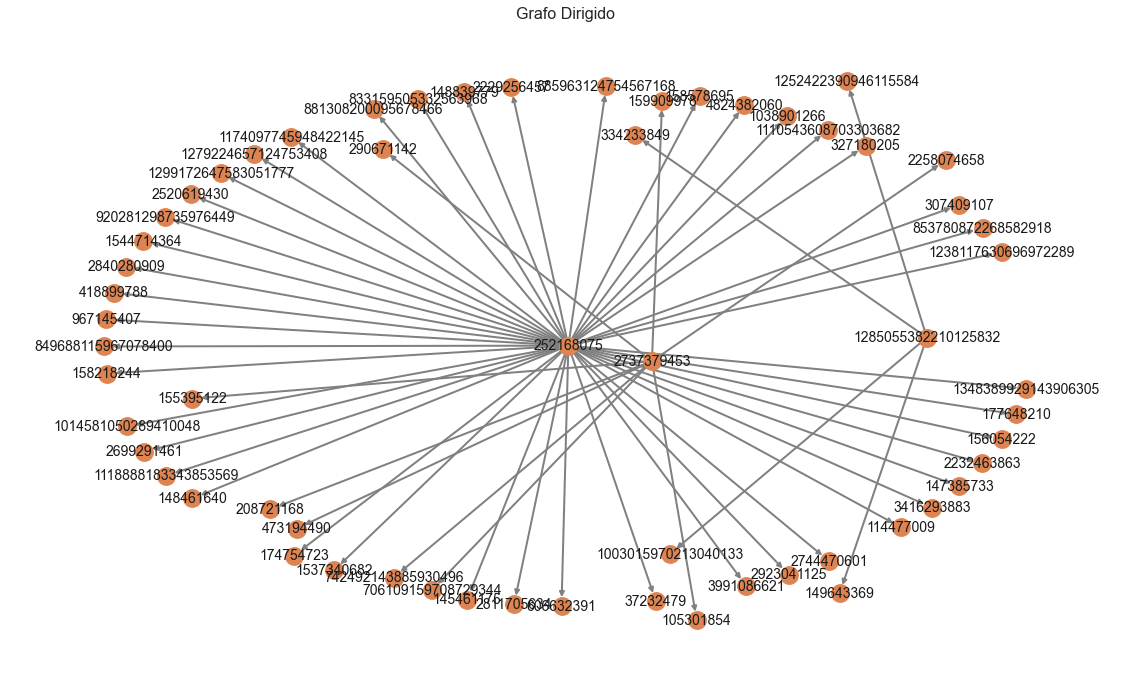

In [13]:
draw_params = dict(
    with_labels=True,               ## Incluye los nombres de los nodos
    node_color='C1',                ## Elijo el color 1 de la paleta de colores
    edge_color='gray',
    width=2,                        ## Espesor de los enlaces
    font_size=14,
    label='',
    pos=nx.kamada_kawai_layout(G_20)   ## Algoritmo para embeber el grafo en el plano
)

fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('Grafo Dirigido', fontsize=16)
nx.draw(
    G_20, 
    ax=ax,
    **draw_params
)

#### Grafo Dirigido

In [14]:
# Creación de un grafo dirigido con la librería NetworkX
Gdir = nx.DiGraph()

#
nodes = df['user.id'].unique()
edges = []
for index, row in df.iterrows():
    largo = len(row['user_retweeters'])
    if largo > 0:
        for i in row['user_retweeters']:
            edges.append((row['user.id'], i))
edges = set(edges)

Gdir.add_nodes_from(nodes)
Gdir.add_edges_from(edges)

print(nx.info(Gdir))

DiGraph with 65934 nodes and 93692 edges


In [15]:
list_degrees_Gdir = sorted([[node, val] for (node, val) in Gdir.degree()], key=lambda x:x[1], reverse = True)
list_degrees_Gdir[:10]

[['252168075', 8366],
 ['130979339', 5558],
 ['73102744', 5367],
 ['367933714', 3852],
 ['593189095', 3835],
 ['2687724840', 3176],
 ['931564592328781824', 3136],
 ['144929758', 2659],
 ['312708081', 1633],
 ['1077176953', 590]]

Exportar Grafo

In [16]:
nx.write_graphml(Gdir,'graph.graphml') # Export NX graph to file

#### Grafo No Dirigido

In [17]:
# Creación de un grafo no dirigido con la librería NetworkX
G = nx.Graph()

#
nodes = df['user.id'].unique()
edges = []
for index, row in df.iterrows():
    largo = len(row['user_retweeters'])
    if largo > 0:
        for i in row['user_retweeters']:
            edges.append((row['user.id'], i))
edges = set(edges)

G.add_nodes_from(nodes)
G.add_edges_from(edges)

print(nx.info(G))

Graph with 65934 nodes and 93404 edges


#### Analisis de "componente gigante"

Intentamos buscar la componente gigante de un grafo dirigido, pero no obtuvimos buenos resultados. Por ende, solo lo hicimos con el grafo no dirigido.

In [18]:
componentGDir = max(nx.connected_components(G), key=len)

#Creamos un grafo reducido
GDir_MaxC = nx.Graph()
GDir_MaxC.add_nodes_from(componentGDir)
GDir_MaxC.add_edges_from(edges)

print(nx.info(GDir_MaxC))

Graph with 39800 nodes and 93404 edges


In [19]:
list_degrees_G = sorted([[node, val] for (node, val) in GDir_MaxC.degree()], key=lambda x:x[1], reverse = True)
list_degrees_G[:10]

[['252168075', 8207],
 ['130979339', 5553],
 ['73102744', 5362],
 ['367933714', 3849],
 ['593189095', 3834],
 ['2687724840', 3175],
 ['931564592328781824', 3136],
 ['144929758', 2657],
 ['312708081', 1630],
 ['1077176953', 589]]

#### Grado medio

In [20]:
degrees = [val for (node, val) in Gdir.degree()]
print(f'Grados Existentes: {set(degrees)}')
print(f'\nMedia de Grados: {statistics.mean(degrees)}')

Grados Existentes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 567, 57, 58, 59, 60, 61, 62, 63, 3136, 64, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 590, 79, 80, 81, 82, 78, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 1633, 97, 2659, 100, 101, 102, 3176, 104, 106, 105, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 122, 123, 127, 129, 133, 134, 135, 136, 137, 142, 143, 147, 149, 151, 152, 153, 154, 157, 161, 162, 163, 165, 167, 170, 8366, 175, 178, 181, 182, 186, 189, 190, 196, 199, 206, 208, 215, 220, 5367, 3835, 252, 251, 3852, 273, 278, 56, 285, 316, 65, 365, 370, 392, 83, 5558, 458}

Media de Grados: 2.8419935086601753


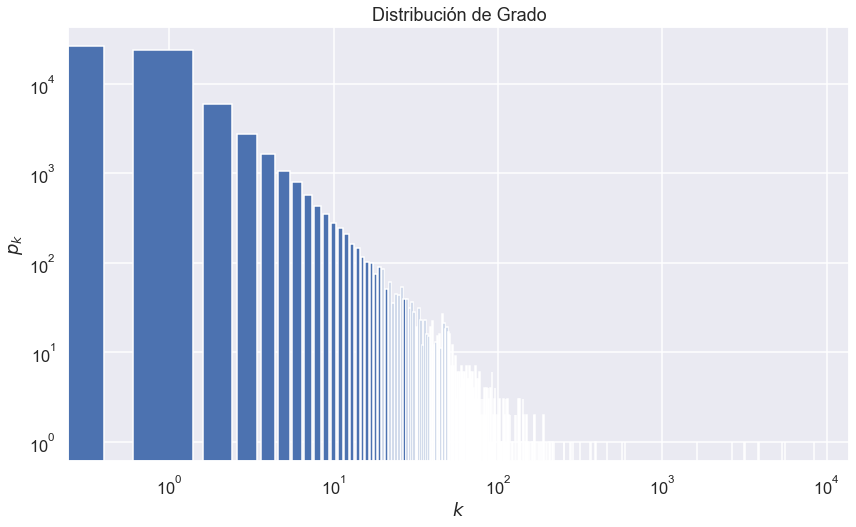

In [21]:
deg_histo = nx.degree_histogram(Gdir)
bins = range(len(deg_histo))

fig, ax = plt.subplots(figsize=(14,8))
ax.set_title('Distribución de Grado')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$p_k$')
plt.xscale("log")
plt.yscale("log")
ax.bar(bins, deg_histo)
plt.show()

#### Asortatividad (assortativity)

Es una característica que tienen los nodos de una red que indica la preferencia por unirse a otros nodos con rasgos característicos similares. \
Se estudia normalmente en función del grado de los nodos, ya que se tienden a unir nodos con un grado similar, se puede medir este nivel de asortatividad con la medida del coeficiente de asortatividad, llamdo también coeficiente de correlación de Pearson. \
Si r da valores positivos, se tendrán correlaciones entre nodos con grado similar, si son negativos se tendrán correlaciones entre nodos con grado diferente. Lo normal es que r tome valores entre -1 y 1, con tres casos absolutos que marcan la asortatividad:
* Si r es igual a -1, tendremos una red disortitiva.
* Si r es igual a 0, se tendrá una red no asortativa (neutral).
* Si r es igual a 1, tendremos una red totalmente asortativa.

In [22]:
r = nx.degree_assortativity_coefficient(Gdir)
print(f'Asortatividad: {r:3.1f}')

Asortatividad: -0.1


#### Transitividad

In [23]:
clustering_coefficient = nx.transitivity(Gdir)
print(f'Transitivity: {clustering_coefficient}')

Transitivity: 0.00033160843475072696


La transitividad se refiere que existe una relación (conexión) entre 2 o más nodos y por decirlo así se puede viajar de cualquiera de los nodos.

#### Coeficiente de clustering de Watts-Strogatz

In [24]:
coef_ws = nx.average_clustering(Gdir)
print(coef_ws)

0.036662170691291136


Dicho coeficiente nos indica cómo que tan **acumulados** están los nodos de la red, y la distancia media entre vértices, que cuantifica, en media, la distancia entre dos vértices cualesquiera.
Este modelo propone redes  pequeñas con mundo cuyas características más sobresalientes son:

*   Un trayecto mínimo promedio entre vértices pequeño, con este concepto estamos definiendo un recorrido de dos vértices que en el mismo contemplan vértices intermedios con distancias relativamente pequeñas. 
*  Un coeficiente de agrupamiento medio elevado: si dos vértices o nodos no están conectados directamente entre sí, entonces existe una gran probabilidad de que se conecten mediante la intervención de otros nodos.

---

### **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.


Creamos un dataframe con los nodos encontrados en nuestro Grafo Direccionado

In [25]:
df_medidas = pd.DataFrame(index=list(Gdir.nodes()))
deg_seq = np.array([k for v, k in Gdir.degree()])
df_medidas['degree'] = deg_seq

Usamos la librería igraph para sacar betweenness, ya que el volumen de datos es muy grande como para Networkx

In [26]:
g_ig = ig.read('graph.graphml',format="graphml") # Create new IG graph from file

#### Betweenness

Para obtener la centralidad de los vértices de un grafo, será necesario saber cuántas veces aparece un vértice en cada camino mínimo posible dentro del grafo. Para ésto, será necesario calcular los caminos mínimos entre todos los pares de vértices (sin ser uno de los extremos). Esto nos dirá cuan seguido se pasa por el vértice en cuestión para llegar a los demás.

In [27]:
betweenness = g_ig.betweenness()

#### Autovector (Eigenvector)

In [28]:
eigenvector = nx.eigenvector_centrality(Gdir)

#### Autovector - Variante Katz

No se calcula, ya que el tiempo que tarda es demasiado y no se encontró otro que lo suplante.

In [29]:
#katz = nx.katz_centrality(Gdir, max_iter=number_of_nodes(Gdir))

 Esta medida analiza el vértice en función de los autovalores y autovectores de la matriz de adyacencia. Para el gráfo en análisis, es demasiado costoso el cálculo del mismo. 

#### Autovector - Variante Page Rank

In [30]:
pagerank = nx.pagerank(Gdir)

Este algoritmo de centralidad de vector propio mide especialmente el grado de influencia de un nodo o vértice dentro de un grafo

#### Cercanía (Closeness)

In [31]:
closeness = g_ig.closeness()

Esta medida nos da el dato del promedio de las distancias del vértice a todos los demás.

Agregamos todos los resultados a nuestro dataframe

In [32]:
df_medidas['betweenness'] = betweenness
df_medidas['eigenvector'] = list(eigenvector.values())
df_medidas['pagerank'] = list(pagerank.values())
#df_medidas['katz'] = list(katz.values())
df_medidas['closeness'] = closeness

#### Distribución

In [33]:
df_medidas.describe()

,degree,betweenness,eigenvector,pagerank,closeness
count,65934.000000,6.593400e+04,6.593400e+04,65934.000000,39743.000000
mean,2.841994,8.273076e+03,1.245038e-03,0.000015,0.278359
std,54.292250,3.834923e+05,3.690091e-03,0.000018,0.086733
min,0.000000,0.000000e+00,4.809031e-22,0.000013,0.130407
25%,0.000000,0.000000e+00,4.809031e-22,0.000013,0.254959
50%,1.000000,0.000000e+00,8.175352e-21,0.000013,0.273192
75%,1.000000,0.000000e+00,6.226832e-07,0.000013,0.284754
max,8366.000000,5.482051e+07,1.364257e-01,0.001347,1.000000


#### Top 10 Centralidad

In [34]:
columns = ['degree', 'betweenness', 'eigenvector', 'pagerank', 'closeness']
data = {}
for col in columns:
    top_rtw = df_medidas.nlargest(10, columns=[col])[col].index  #top 5 de las medidas de centralidad, buscamos el dato mas repetido 
    data[col] = top_rtw
pd.DataFrame(data)

,degree,betweenness,eigenvector,pagerank,closeness
0,252168075,252168075,1167510078649487361,396312747,1257089710897401857
1,130979339,312708081,252168075,315864204,131418981
2,73102744,1163957624368521217,315864204,1167510078649487361,1125618989646872578
3,367933714,130979339,396312747,144311959,918008048
4,593189095,3421061763,4220072895,1249752252740403200,1047160180591550465
5,2687724840,2687724840,1233264558707527681,149762941,201924584
6,931564592328781824,4343677427,762686650715701248,762686650715701248,2427097620
7,144929758,1345500851117428736,299375176,1188801412337225729,229516510
8,312708081,60909246,1210378599238422528,1233264558707527681,835601672
9,1077176953,149762941,1062010454854324225,1210378599238422528,2302883271


---


### **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

**Opcional:** Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

In [35]:
def run_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = {}
    if logspace:
        resolutions = np.logspace(np.log10(min_res), np.log10(max_res), samples)
    else:
        resolutions = np.linspace(min_res, max_res, samples)
    for resolution in resolutions:
        comms = algorithms.louvain(
            g, weight='weight', resolution=resolution, randomize=False
        )
        comms_dict[resolution] = comms
    return comms_dict

def plot_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = run_louvain(g, min_res, max_res, samples)
    resolutions = comms_dict.keys()
    Q_values = [evaluation.newman_girvan_modularity(g, comms).score for comms in comms_dict.values()]
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_ylabel('Q')
    ax.set_xlabel('Resolution')
    ax.set_xscale('log')
    ax.plot(resolutions, Q_values, '-', label='Louvain')
    ax.legend()
    return ax

#### Algoritmo de Louvain

El algoritmo de Louvain es un algoritmo que responde a los métodos de modularidad para determinar la existencia de comunidades dentro de los conjuntos de datos. Este algoritmo estudia y evalua los conjuntos de datos para establecer una relación de contraste en términos de densidad de las aristas que se encuentran en el conjunto de datos bien sean internas o externas.  Con los resultados producto del algoritmo se obtiene un estimado de agrupación de todos los nodos que pertenecen a una red específica.

In [36]:
comms_louvain = algorithms.louvain(G, weight='weight', resolution=1, randomize=False)

#### Comunidades louvain

Como podemos ver, tenemos muchas comunidades, las cuales insertaremos en un dataframe de Pandas para poder tratarlo.

In [89]:
dict_comms = {'ncomms': np.arange(len(comms_louvain.communities)),
              'size': [len(x) for x in comms_louvain.communities],
              'users': [x for x in comms_louvain.communities]
             }

df_comms_louvain = pd.DataFrame(dict_comms).sort_values(by=['size'], ascending=False)
df_comms_louvain.head(20)

,ncomms,size,users
0,0,8093,"[1438195184, 73102744, 840377572038983680, 107..."
1,1,7314,"[2737379453, 484349869, 1297307280938065921, 9..."
2,2,6991,"[252168075, 1285055382210125832, 9269698582810..."
3,3,4781,"[10427162, 1348193396, 726631311771852804, 186..."
4,4,3387,"[600710938, 151929451, 1089559024620789762, 90..."
5,5,3250,"[442142518, 167939347, 71906128, 1214951596137..."
6,6,2937,"[719331994665099264, 1433751968, 2178330104, 1..."
7,7,589,"[1225934818745167873, 180406199, 1138390137673..."
8,8,521,"[1320842148103786497, 110468150, 9569812482992..."
9,9,273,"[955125798750564357, 789084316068356096, 47605..."


In [38]:
df_comms_louvain.describe()

,ncomms,size
count,26490.000000,26490.000000
mean,13244.500000,2.489015
std,7647.148652,91.552866
min,0.000000,1.000000
25%,6622.250000,1.000000
50%,13244.500000,1.000000
75%,19866.750000,1.000000
max,26489.000000,8093.000000


Podemos ver que Louvain encontró dentro de las primeras 6 comunidades las más numerosas. A partir de esta, el numero de cantidad de nodos baja considerablemente.

Visualizamos sobre un gráfico de barras de las primeras 30 comunidades, ya que mirar todas las comunidades pequeñas no es relevante.

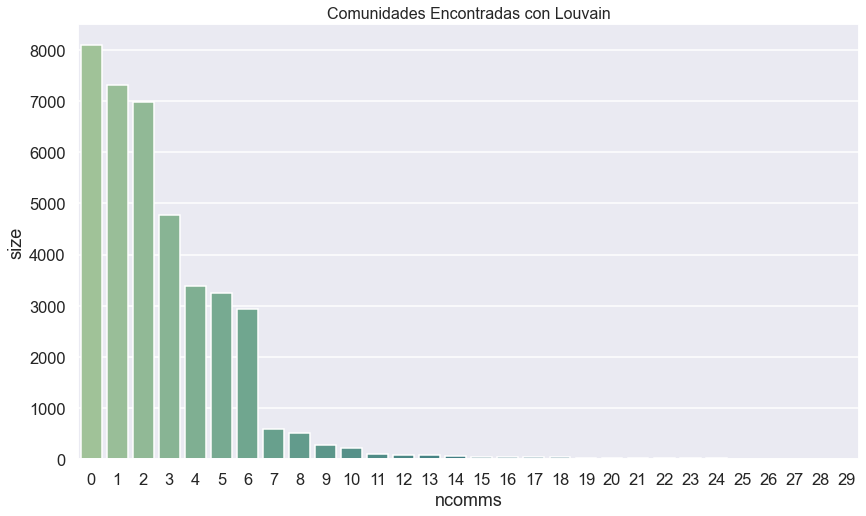

In [39]:
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df_comms_louvain[:30],x='ncomms', y='size', palette='crest')
plt.title('Comunidades Encontradas con Louvain', fontsize=16)
plt.show()

#### Modularidad

In [40]:
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(G, comms_louvain))

Comunidades encontradas: FitnessResult(min=None, max=None, score=0.5648973911603585, std=None)


#### Densidad Interna

Analizamos la densidad de las comunidades resultantes

In [41]:
m = G.number_of_edges()
N = G.number_of_nodes()
print('Densidad del grafo:', m/(N*(N-1)/2))

Densidad del grafo: 4.2971766792413005e-05


In [42]:
print('Comunidades encontradas:', evaluation.internal_edge_density(G, comms_louvain))

Comunidades encontradas: FitnessResult(min=0, max=3.0, score=0.009658266429210222, std=0.09940776211053243)


#### **Índice de corte**

Es el promedio de la fracción de enlaces entre pares de comunidades

In [43]:
print('Comunidades encontradas:', evaluation.cut_ratio(G, comms_louvain))

Comunidades encontradas: FitnessResult(min=0.0, max=2.7582019610053037e-05, score=1.69080850681107e-08, std=5.204826670471932e-07)


#### Variar Resolución

Tener cuidado al correr, dura media hora aproximadamente.

<AxesSubplot:xlabel='Resolution', ylabel='Q'>

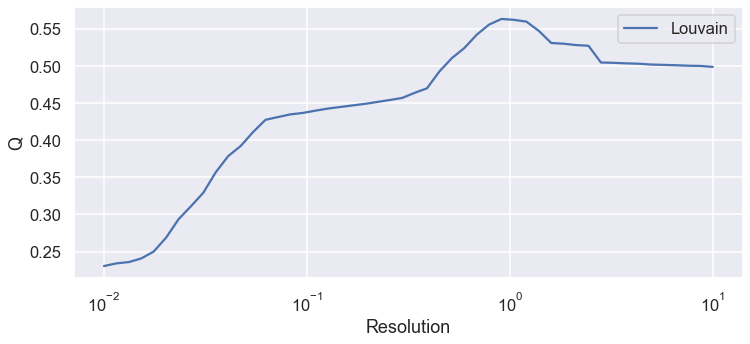

In [ ]:
plot_louvain(G, min_res=0.01, max_res=10, samples=50, logspace=True)

En el gráfico anterior, podemos observar 50 muestras de resoluciones que van desde el 0.01 hasta el 10. Los mejores resultados en la modularidad fueron los que se encuentran cerca de 1.

#### Algoritmo de Leiden

El algoritmo de Leiden es una mejora del algoritmo de Louvain. El algoritmo de Leiden consta de tres fases:
1. Desplazamiento local de los nodos
2. Refinamiento de la partición.
3. Agregación de la red basada en la partición refinada, utilizando la partición no refinada para crear una partición inicial para la red agregada.

El algorítmo de Leiden soporta grafos de tipo unidireccional.

Fuente: [Algoritmo Leiden](https://cdlib.readthedocs.io/en/latest/reference/cd_algorithms/algs/cdlib.algorithms.leiden.html)

In [44]:
comms_leiden = algorithms.leiden(G)

In [45]:
ncomms_leiden = len(comms_leiden.communities)
Q = evaluation.newman_girvan_modularity(G, comms_leiden).score

In [46]:
print(f'Cantidad de comunidades: {ncomms_leiden}')
print(f'Modularidad: {Q}')

Cantidad de comunidades: 26527
Modularidad: 0.5866256748861248


#### Comunidades Leiden

Como podemos ver, tenemos muchas comunidades, las cuales insertaremos en un dataframe de Pandas para poder tratarlo.

In [86]:
dict_comms = {'ncomms': np.arange(len(comms_leiden.communities)),
              'size': [len(x) for x in comms_leiden.communities],
              'users': [x for x in comms_leiden.communities]
             }

df_comms_leiden = pd.DataFrame(dict_comms).sort_values(by=['size'], ascending=False)
df_comms_leiden.head(20)

,ncomms,size,users
0,0,7518,"[252168075, 1285055382210125832, 470810678, 89..."
1,1,7277,"[1438195184, 73102744, 840377572038983680, 107..."
2,2,6492,"[2737379453, 484349869, 1297307280938065921, 9..."
3,3,4477,"[10427162, 984448926395793408, 1348193396, 715..."
4,4,3767,"[1433751968, 726631311771852804, 370869182, 21..."
5,5,3421,"[442142518, 71906128, 125077217, 319802534, 33..."
6,6,3377,"[151929451, 311157527, 1089559024620789762, 90..."
7,7,565,"[180406199, 1138390137673572353, 109320308, 12..."
8,8,480,"[546205762, 1225934818745167873, 1304123372704..."
9,9,234,"[2216772987, 4197549682, 789084316068356096, 9..."


In [87]:
df_comms_leiden.describe()

,ncomms,size
count,26527.000000,26527.000000
mean,13263.000000,2.485543
std,7657.829632,88.888743
min,0.000000,1.000000
25%,6631.500000,1.000000
50%,13263.000000,1.000000
75%,19894.500000,1.000000
max,26526.000000,7518.000000


Podemos ver que Leiden se comporta de manera similar a Louvain.

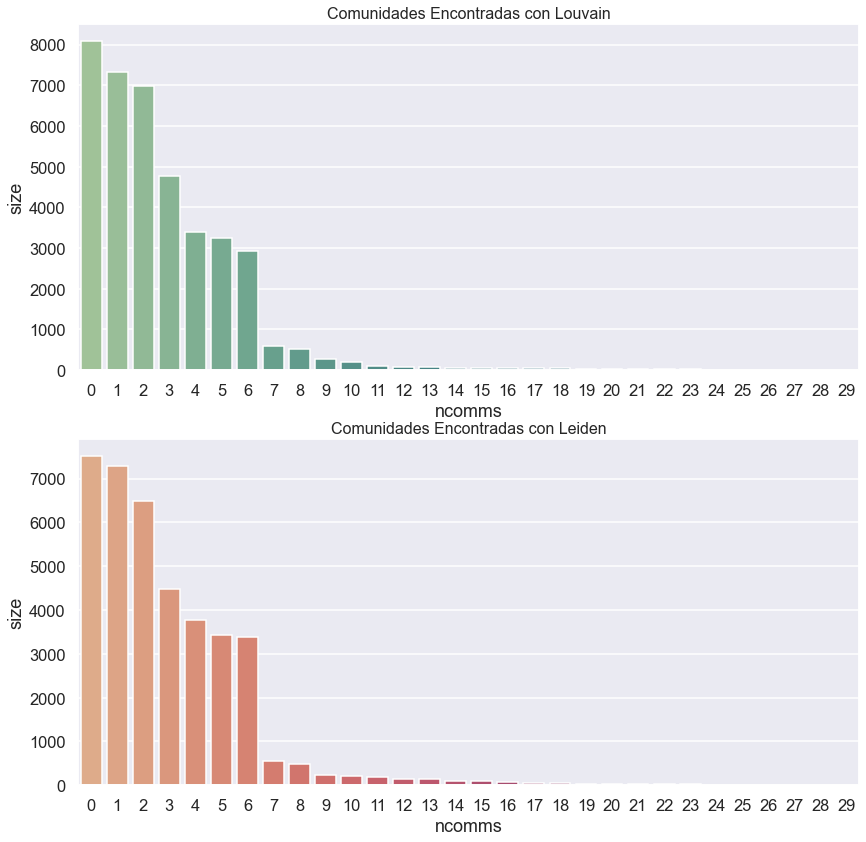

In [49]:
fig, ax = plt.subplots(2,1,figsize=(14,14))
sns.barplot(data=df_comms_louvain[:30],x='ncomms', y='size', palette='crest', ax=ax[0])
sns.barplot(data=df_comms_leiden[:30],x='ncomms', y='size', palette='flare', ax=ax[1])
ax[0].set_title('Comunidades Encontradas con Louvain', fontsize=16)
ax[1].set_title('Comunidades Encontradas con Leiden', fontsize=16)
plt.show()

---

## Segunda parte

### **4. Extracción de etiquetas**

En el archivo [etiquetas.csv](https://drive.google.com/file/d/1LWY3VoIRt0xKwEbbtMXYePOGZvgPsQh-/view?usp=sharing) están las etiquetas para un pequeño subconjunto de nodos. Podemos interpretar el valor de la etiqueta como la pertenencia a una determinada clase, donde los usuarios de una misma clase en general tienden a expresar apoyo entre sí.

- Determinar quiénes son los usuarios referentes de cada clase (utilizar alguna medida de centralidad calculada sobre el grafo de retweets).
- Utiliando los resultados del práctico anterior, determinar si los usuarios de cada clase forman parte de distintas comunidades.

**Opcional:** Reconstruir el archivo "etiquetas.csv". Para eso, hacer lo siguiente

- Construir un grafo en donde los nodos sean usuarios, y donde los enlaces unan dos nodos si entre ellos hubo más respuestas de apoyo que de oposición.
- Extraer las dos componentes más grandes del grafo. Esos serán nuestros nodos etiquetados.

In [25]:
df_targets = pd.read_csv(DATA_DIR / 'etiquetas.csv', dtype=dtypes)
df_targets.head()

,user.id,Clase
0,1227432088925851650,0
1,1148843472,0
2,1329815581302853632,0
3,131669966,0
4,811607948,0


In [26]:
df_targets.shape

(196, 2)

In [27]:
df_tw_sent = df_medidas.reset_index().merge(df_targets, left_on='index', right_on='user.id').drop(columns=['user.id'])
df_tw_sent.rename(columns={'index': 'user'}, inplace=True)
print(f'Dimensionalidad: {df_tw_sent.shape}')
df_tw_sent.head()

NameError: name 'df_medidas' is not defined

#### Usuarios referentes de cada clase

Clase 0

In [ ]:
columns = ['degree', 'betweenness', 'eigenvector', 'pagerank', 'closeness']
data = {}
for col in columns:
    top_rtw = df_tw_sent[df_tw_sent.Clase==0].nlargest(10, columns=[col])['user'].tolist()  #top 5 de las medidas de centralidad, buscamos el dato mas repetido 
    data[col] = top_rtw
pd.DataFrame(data)

In [ ]:
df[df['user.id'].isin(['252168075','510740590'])]

---
Conclusión (Clase 0)

Podemos tomar dos referentes principales que mejor se posicionan en nuestras medidas de centralidad. \
Estos usuarios son:
* 252168075
* 510740590
---

Clase 1

In [ ]:
columns = ['degree', 'betweenness', 'eigenvector', 'pagerank', 'closeness']
data = {}
for col in columns:
    top_rtw = df_tw_sent[df_tw_sent.Clase==1].nlargest(10, columns=[col])['user'].tolist()  #top 5 de las medidas de centralidad, buscamos el dato mas repetido 
    data[col] = top_rtw
pd.DataFrame(data)

---
Conclusión (Clase 1)

Aquí los tops obtenidos para los referentes en cada medida de centralidad variada por lo cual, tomaremos el top 1 de las medidas de degree, betweennes y closeness, y veremos dónde se repite ese usuario. \
Los usuarios son:
* 73102744: Con mayor degree, pero en betweenness tiene la 5ta posición y en closeness tiene la 4ta. Esto quiere decir, que por más que tenga un grado alto de conexión, no es el nodo recurrente por el que pasan los demás, y en promedio queda cuarto en ser el nodo con distancias a todos los demás.
* 3421061763: Es el nodo recurrente por el que el resto de los demás nodos con clase 1 pasan, más allá que sea 4to en degree y queda 3ro en los nodos con distancia promedio a las demás.
* 206371045: 9no en degree, es decir, conexiones. Termina siendo tercero en la medida de betweenness y es el primero en distancia promedio respecto a los demás.
---

#### Determinar si los usuarios de cada clase forman parte de distintas comunidades

In [85]:
len(df_tw_sent[df_tw_sent.Clase==0].user.unique())

107

In [98]:
users_C0 = df_tw_sent[df_tw_sent.Clase==0].user.unique()
users_C1 = df_tw_sent[df_tw_sent.Clase==1].user.unique()

dict_user_comm = {'user': [],
                  'comm': [],
                  'clase': []
                 }

for index, row in df_comms_louvain.iterrows():
    for i in users_C0:
        if i in row['users']:
            dict_user_comm['user'].append(i)
            dict_user_comm['comm'].append(row['ncomms'])
            dict_user_comm['clase'].append(0)

for index, row in df_comms_louvain.iterrows():
    for i in users_C1:
        if i in row['users']:
            dict_user_comm['user'].append(i)
            dict_user_comm['comm'].append(row['ncomms'])
            dict_user_comm['clase'].append(1)

In [100]:
df_user_comm_clase = pd.DataFrame(dict_user_comm)

In [111]:
df_user_comm_clase[df_user_comm_clase.clase==0][['clase','comm']].value_counts().to_frame().reset_index()

,clase,comm,0
0,0,1,67
1,0,2,17
2,0,8323,1
3,0,23610,1
4,0,21524,1
5,0,20550,1
6,0,18873,1
7,0,17394,1
8,0,14530,1
9,0,14449,1


Para la clase 0, podemos observar 25 comunidades hayadas. \
Esta clasificación por Louvain es bastante buena, ya que en los primeras 2 comunidades (comunidad 1 y 2), se encuentra una distribución más concentrada de usuarios.

In [112]:
df_user_comm_clase[df_user_comm_clase.clase==1][['clase','comm']].value_counts().to_frame().reset_index()

,clase,comm,0
0,1,0,52
1,1,3,8
2,1,4,3
3,1,5,2
4,1,7044,1
5,1,22199,1
6,1,20380,1
7,1,17108,1
8,1,17101,1
9,1,17075,1


Como podemos observar, en el caso de la clase 1, se obtienen 28 comunidades diferentes. \
Aquí la clasificación también es bastante favorable, ya que la mayoría de usuarios de clase 1 se concentró en la comunidad 0.

---

### **5. Embedding de nodos**

- Generar un embedding del grafo de retweets utilizando el algoritmo `word2vec`.
- Reducir a 2 la dimensionalidad del embedding utilizando [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.htmlhttps://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).
- Graficar los embeddings correspondientes a los datos etiquetados. ¿Es posible diferenciar unos de otros?

**Opcional:** Graficar además los embeddings de los nodos que forman parte de las comunidades asociadas a cada clase. Determinar si el embedding permite distinguir cada comunidad.

Generamos un csv para ser subido a Colab y correr este punto allí

In [31]:
df.merge(df_targets).drop(columns=['created_at','full_text','in_reply_to_status_id','in_reply_to_user_id','sentiment']).to_csv('.\data\twitter\embeding_twitter.csv')

In [ ]:
from google.colab import files
uploaded = files.upload()

In [3]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}

df_colab = pd.read_csv('embeding_twitter', dtype=dtypes).dropna(subset=['user_retweeters'])
df_colab['user_retweeters'] = df_colab['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df_colab.shape)
df_colab.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


In [122]:
import torch 
import torch_geometric

ModuleNotFoundError: No module named 'torch_sparse'

In [120]:
## Elegimos si usar CPU o GPU para los cálculos 
device = "cuda" if torch.cuda.is_available() else "cpu" #le decimos que dispositivo usamos
print("Using {} device".format(device))

Using cpu device


In [ ]:
import numpy as np
import networkx as nx

from torch_geometric.nn import Node2Vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

In [ ]:
#CARGAMOS DF
g = nx.karate_club_graph()
print(nx.info(g))

In [ ]:
n = g.number_of_nodes()
nodes = [v for v in g.nodes()]
membership = np.array([g.nodes[v]['user.id'] for v in g])

In [ ]:
#generamos matriz esparsa
adj = nx.to_scipy_sparse_matrix(g).tocoo() #guarda las deribadas
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)
edge_index #son dos matrices 

In [ ]:
## Definimos nuestro modelo
model = Node2Vec( #le damos la matriz de adyacencia
    edge_index, embedding_dim=100, walk_length=10, 
    context_size=4, num_negative_samples=5 #cantidad de sampleo negativo
).to(device) #arquitectura y funcion de costo 

## El loader es un wrapper que nos permite trabajar por lotes, 
## para utilizar descenso por el gradiente estocástico y
## sus variantes
loader = model.loader(batch_size=128, shuffle=True) #estimamos el gradiente con este lote de datos

## Optimizador
optimizer = torch.optim.Adam(list(model.parameters()), lr=0.01) 

In [ ]:
#definimos funcion de entrenamiento
def train():
    ## Ponemos nuestro modelo en modo entrenamiento
    model.train()

    total_loss = 0
    for pos_rw, neg_rw in loader: #iteramos 

        ## Reseteamos los gradientes en cada iteracion partimos de 0
        optimizer.zero_grad()

        ## Calculamos el error (la función de costo) del lote
        ## en función de los samples positivos y negativos
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))

        ## Hacemos backpropagation
        loss.backward()

        ## Avanzamos un paso
        optimizer.step()

        ## Actualizamos la función de costo total
        total_loss += loss.item()

    return total_loss / len(loader)

In [ ]:
#entrenamos modelo
epochs = 100
for epoch in range(epochs): #calculamos el costo
    loss = train() 
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3} - Loss: {loss:.3f}')

In [ ]:
def get_embedding(): #
    model.eval() #pone el modelo en modo evalucacion
    with torch.no_grad(): #no calcula ningun gradiente lo quiero como estan ahora
        nodes = torch.arange(g.number_of_nodes(), device=device)  #evaluo el modelo en todos lo nodos
        embedding = model(nodes).detach().numpy()
    return embedding

embedding = get_embedding()
embedding.shape

In [ ]:
#reducimos dimencionalidad
pca = PCA(n_components=2, random_state=22).fit_transform(embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='pca', random_state=22).fit_transform(embedding)

In [ ]:
#graficamos
def add_labels(g, pos, ax):
    labels = [v for v in g.nodes()]
    for i in range(g.number_of_nodes()):
        x, y = pos[i]
        label = labels[i]
        ax.text(x, y, label)

color = ['C0' if elem == 'user.id' else 'C1' for elem in membership]  #ver el nombre
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols, 8), ncols=2)
ax = axes[0]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('PCA')
ax.scatter(pca[:,0], pca[:,1], c=color)
add_labels(g, pca, ax)
ax = axes[1]
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title('t-SNE')
ax.scatter(tsne[:,0], tsne[:,1], c=color)
add_labels(g, tsne, ax)
plt.tight_layout()
plt.show()

### **Opcional: 6. Redes neuronales de grafos**

El archivo word_vectors.csv contiene un embedding de 300 dimensiones para cada tweet, otenido utilizando un modelo preentrenado de FastText. Construir una matriz de features para los nodos tomando, para cada usuario, el promedio de los vectores correspondientes a los tweets que escribió. Utilizando estos features, y tomando como ejemplos etiquetados los usuarios de "etiquetas.csv" entrenar una red neuronal de grafos para realizar una clasificación binaria sobre el resto de los nodos. Pueden utilizar como base el siguiente modelo:# Práctico 1